In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
% matplotlib inline
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
import numpy as np
import math
from scipy.signal import welch

Moran and Colleagues Neural Mass Model in PyRates
==========================

**1. Model Description**
    - Circuit set-up
    - spike-frequency-adaptation mechanism

**2. PyRates Implementation**
    - Axon
    - Synapses
    - Population
    - Circuit

**3. Model Validation**
    - Replicating Moran et al. (2007), single circuit frequency response

1. Model Description
--------------------

**Circuit Structure**

<img src="img/Moran_circuit.png",width=400,height=400>

    - Model set-up based on Jansen & Rit (1995)
    - See JansenRit_Doc.ipynb for a description of the mathematical formalism
    - Added an inhibitory feedback loop to the inhibitory interneurons
    - Added a spike-frequency adaptation mechanism

**Spike-Frequency-Adaptation Mechanism**

The spike-frequency adaptation mechanism is based on the universal phenomenological model proposed by Brenda & Herz (2003). The adaptation shifts the sigmoidal transfer function that calculates the average firing rate of a population from its average membrane potential on the x-axis. This corresponds to lowering/increasing the average firing threshold of a population. The adaptation dynamics are described as follows:

<br/>

$$\dot{a(t)} = \frac{(S(v(t) - a) - a)}{tau_a}$$

$a = $  firing threshold adaptation <br/>
$S = $ sigmoidal transform <br/>
$v = $ average membrane potential <br/>
$tau_a = $ time constant of the spike-frequency adaptation <br/>


2. PyRates Implementation
-------------------------

**Axon**

Implements the transform from average membrane potential to average firing rate.


Default maximum firing rate (2*e0):  1.0  Hz.
Default membrane potential threshold (v0):  0.001  V.
Default sigmoid steepness (r):  2000.0  Hz.


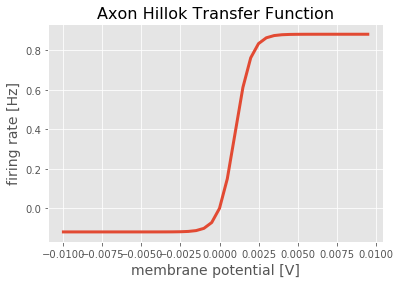

In [2]:
from core.axon import MoranAxon

# initialize axon
axon = MoranAxon()

# print default parameters (can be changed during initialization)
print('Default maximum firing rate (2*e0): ', axon.transfer_function_args['max_firing_rate'], ' Hz.')
print('Default membrane potential threshold (v0): ', axon.transfer_function_args['membrane_potential_threshold'], ' V.')
print('Default sigmoid steepness (r): ', axon.transfer_function_args['sigmoid_steepness'], ' Hz.')

# plot axon
fig, axes = plt.subplots()
membrane_potentials = np.arange(-0.01, 0.01, 0.0005)
axes = axon.plot_transfer_function(membrane_potentials, create_plot=False, axes=axes)

**Synapses**

Implement the transform from average firing rate into average membrane potential.

Default synaptic efficacies (He/Hi):  [0.004, -0.032]  V.
Default synaptic time constants (tau_e/tau_i):  [0.004, 0.016]  s.


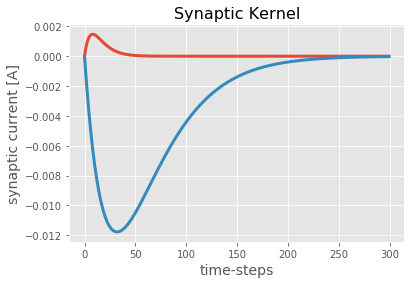

In [3]:
from core.synapse import MoranExcitatorySynapse, MoranInhibitorySynapse

# instantiate an excitatory and an inhibitory synapse
synapse_e = MoranExcitatorySynapse(bin_size=5e-4, max_delay=0.15)
synapse_i = MoranInhibitorySynapse(bin_size=5e-4, max_delay=0.15)

# print default parameters (can be changed during initialization)
print('Default synaptic efficacies (He/Hi): ', [synapse_e.efficacy, synapse_i.efficacy], ' V.')
print('Default synaptic time constants (tau_e/tau_i): ', [synapse_e.kernel_function_args['tau'], synapse_i.kernel_function_args['tau']], ' s.')

# plot synaptic kernels
fig, axes = plt.subplots()
axes = synapse_e.plot_synaptic_kernel(create_plot=False, axes=axes)
axes = synapse_i.plot_synaptic_kernel(create_plot=False, axes=axes)

**Populations**
    
    - 3 types: Pyramidal cells, excitatory interneurons, inhibitory interneurons
    - Consist of a Moran axon and an excitatory Moran synapse
    - Pyramidal cells and inhibitory interneurons have an additional inhibitory Moran synapse
    - Pyramidal cells have spike-frequency adaptation enabled for their connection to the excitatory interneurons

Text(0.5,1,'IINs')

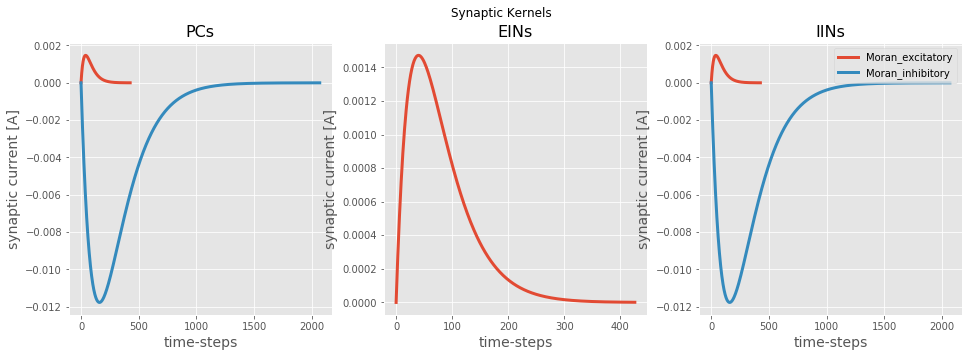

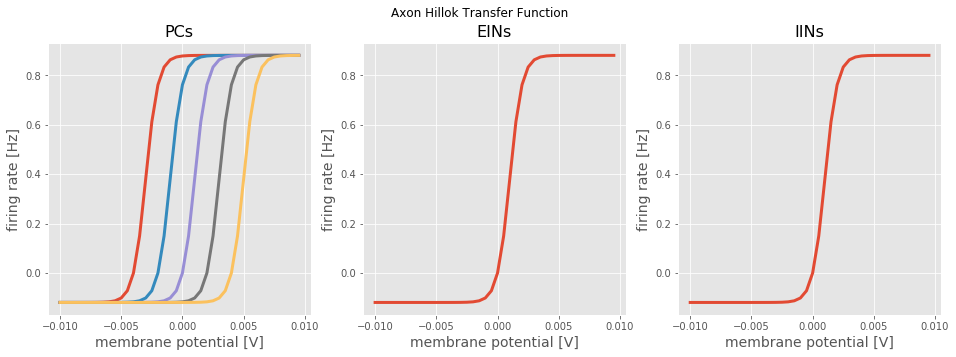

In [73]:
from core.population import MoranPyramidalCells, MoranExcitatoryInterneurons, MoranInhibitoryInterneurons

# parameters
step_size = 1e-4
synapse_params = {'epsilon': 1e-6}

# instantiate all 3 populations
pcs = MoranPyramidalCells(step_size=step_size, synapse_params=[synapse_params, synapse_params])
eins = MoranExcitatoryInterneurons(step_size=step_size, synapse_params=[synapse_params])
iins = MoranInhibitoryInterneurons(step_size=step_size, synapse_params=[synapse_params, synapse_params])

# plot synaptic kernels of each population
fig, axes = plt.subplots(1,3, figsize=(16,5))
plt.suptitle('Synaptic Kernels')
ax1 = axes[0]
ax1 = pcs.plot_synaptic_kernels(create_plot=False, axes=ax1)
ax1.set_title('PCs')
ax2 = axes[1]
ax2 = eins.plot_synaptic_kernels(create_plot=False, axes=ax2)
ax2.set_title('EINs')
ax3 = axes[2]
ax3 = iins.plot_synaptic_kernels(create_plot=False, axes=ax3)
ax3.set_title('IINs')

# plot axonal transfer function for each population
fig, axes = plt.subplots(1,3, figsize=(16,5))
plt.suptitle('Axon Hillok Transfer Function')
ax1 = axes[0]
adaptations = [-0.004, -0.002, 0., 0.002, 0.004]
for a in adaptations:
    pcs.axon.transfer_function_args['adaptation'] = a
    ax1 = pcs.axon.plot_transfer_function(membrane_potentials, create_plot=False, axes=ax1)
ax1.set_title('PCs')
ax2 = axes[1]
ax2 = eins.axon.plot_transfer_function(membrane_potentials, create_plot=False, axes=ax2)
ax2.set_title('EINs')
ax3 = axes[2]
ax3 = iins.axon.plot_transfer_function(membrane_potentials, create_plot=False, axes=ax3)
ax3.set_title('IINs')

**Circuit**

 Models cortical column as interaction between PCs (plastic + non-plastic), EINs and IINs.

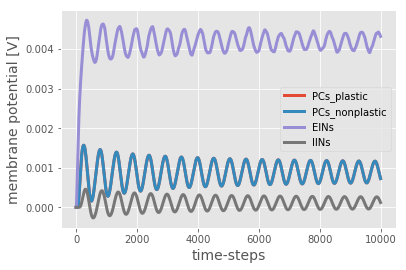

In [15]:
from core.circuit import MoranCircuit

# parameters
step_size = 1e-4
simulation_time = 1.
time_steps = int(simulation_time/step_size)

# instantiate circuit
mc = MoranCircuit(step_size=step_size, tau=None)

# define input to circuit
synaptic_input = np.zeros((time_steps, 4, 2))                      # time-steps x 4 populations x 2 synapses
synaptic_input[:, 2, 0] = 22 * np.random.randn(time_steps) + 220   # gaussian input to EINs

# simulate circuit behavior
mc.run(simulation_time=simulation_time, synaptic_inputs=synaptic_input)

# plot resulting membrane potential traces
fig, axes = plt.subplots()
axes = mc.plot_population_states(create_plot=False, axes=axes)

3. Model Validation
-------------------

**Replicating Moran et al. (2007)**

*Single circuit power spectrum:*

    - Circuit with parametrization as reported above, consisting of PCs, EINs and IINs
    - Simulation of circuit behavior for 10 s 
    - White noise input with mean = 220 Hz and var = 22 Hz delivered to PCs throughout the simulation
    - Conditions for excitatory synapse efficacy: 0.01 - 0.03 V.
    - Results can be seen in figure below
    
<img src="img/Moran_power_spectrum.png",width=400,height=400>

*Replication of the single circuit experiment with PyRates:*

In [16]:
from core.circuit import MoranCircuit

# simulation parameters
step_size = 1e-4
simulation_time = 10.
time_steps = int(simulation_time / step_size)

# instantiate circuit
mc = MoranCircuit(step_size=step_size, tau=None)

# define experimental conditions
synaptic_input = np.zeros((time_steps, 4, 2))                      # n_timesteps x n_populations x n_synapses
synaptic_input[:, 2, 0] = 22. * np.random.randn(time_steps) + 220  # white noise input to EINs
efficacies = np.arange(10, 31, 1) * 1e-3                           # different excitatory synapse efficacies 

# perform experiment for each condition
pc_state_col = list()

for H_e in efficacies:
    
    # update excitatory synapse time-scale
    for i in range(mc.N):        
        mc.populations[i].synapses[0].efficacy = H_e
        mc.populations[i].synapses[0].update()
        
    # run simulation
    mc.run(synaptic_inputs=synaptic_input, simulation_time=simulation_time)
    
    # save population states
    pc_state_col.append(np.squeeze(mc.get_population_states(0, [0], time_window=[1., simulation_time])))
    
    # clear population states
    mc.clear()

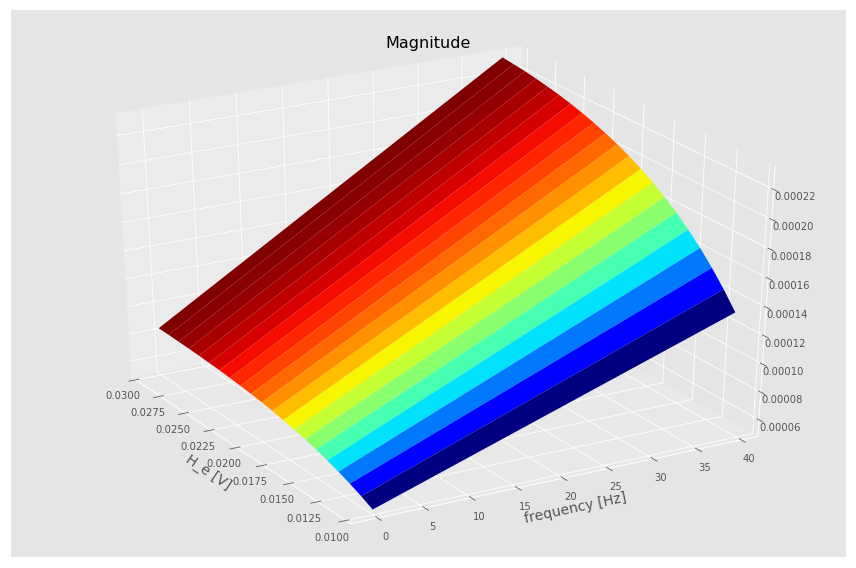

In [18]:
# analyze and plot results

# get power spectrum for 0-60 Hz frequency band for each condition
psds = list()

for i in range(len(pc_state_col)):
    
    # calculate power spectrum
    f, p = welch(pc_state_col[i], fs=1./step_size, scaling='density')
    
    # save power spectrum for 0-60 Hz frequency band
    psds.append(np.sqrt(p[f <= 60.]))

psds = np.array(psds)

# create surface plot of power spectra over conditions
Y = f[f <= 60]
X = efficacies
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, psds.T, cmap='jet')
ax.set_xlim(np.max(efficacies), np.min(efficacies))
ax.view_init(30, 330)
ax.set_title('Magnitude')
ax.set_xlabel('H_e [V]')
ax.set_ylabel('frequency [Hz]')
plt.tight_layout()